Méthode Fama-Macbeth

In [53]:
import warnings
warnings.filterwarnings('ignore') # pour éviter les avertissements et errors dans certaines manipulations

In [54]:
import pandas as pd # pour manipuler des dataframes
import numpy as np # pour manipuler des tableaux
from statsmodels.api import OLS, add_constant # pour réaliser des régression linéaires
import pandas_datareader.data as web # pour extraire des données
import pandas_datareader.famafrench as ff # pour ccéder au module de famafrench
from linearmodels.asset_pricing import LinearFactorModel # pour calculer des betas
import matplotlib.pyplot as plt # pour dessiner
import seaborn as sns # pour dessiner
from datetime import datetime # pour manipuler des dates
import yfinance as yf # pour importer des données boursières de yahoo finance

In [55]:
sns.set_style('whitegrid') # facultatif, juste pour le style de certains graphiques, une grille une fond

#### Voici le site de Fama et French sur lequel vous trouverez en libre accès des données pour réaliser nos modèles https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

In [56]:
# Regardons dans un premier temps tous les datasets disponibles dans le module famafrench

# code pour récupérer tous les datasets disponibles dans la module famafrench
famafrench_datasets = ff.get_available_datasets()

# On a récupéré les datasets disponibles juste au dessus, on fait une boucle pour
# imprimer leur nom un par un 
for dataset in famafrench_datasets:
    print(dataset)

F-F_Research_Data_Factors
F-F_Research_Data_Factors_weekly
F-F_Research_Data_Factors_daily
F-F_Research_Data_5_Factors_2x3
F-F_Research_Data_5_Factors_2x3_daily
Portfolios_Formed_on_ME
Portfolios_Formed_on_ME_Wout_Div
Portfolios_Formed_on_ME_Daily
Portfolios_Formed_on_BE-ME
Portfolios_Formed_on_BE-ME_Wout_Div
Portfolios_Formed_on_BE-ME_Daily
Portfolios_Formed_on_OP
Portfolios_Formed_on_OP_Wout_Div
Portfolios_Formed_on_OP_Daily
Portfolios_Formed_on_INV
Portfolios_Formed_on_INV_Wout_Div
Portfolios_Formed_on_INV_Daily
6_Portfolios_2x3
6_Portfolios_2x3_Wout_Div
6_Portfolios_2x3_weekly
6_Portfolios_2x3_daily
25_Portfolios_5x5
25_Portfolios_5x5_Wout_Div
25_Portfolios_5x5_Daily
100_Portfolios_10x10
100_Portfolios_10x10_Wout_Div
100_Portfolios_10x10_Daily
6_Portfolios_ME_OP_2x3
6_Portfolios_ME_OP_2x3_Wout_Div
6_Portfolios_ME_OP_2x3_daily
25_Portfolios_ME_OP_5x5
25_Portfolios_ME_OP_5x5_Wout_Div
25_Portfolios_ME_OP_5x5_daily
100_Portfolios_ME_OP_10x10
100_Portfolios_10x10_ME_OP_Wout_Div
100_Port

In [76]:
# On choisit le dataset F-F_Research_Data_5_Factors_2x3 
famafrench_factor = 'F-F_Research_Data_5_Factors_2x3'

# Maintenant on récupère ce dataset avec web.DataReader
# On donne à la fonction le nom du dataset, la data source et la période
# Ici on ne précise pas encore les dates qu'on veut récupérer, dans un premier temps on regarde
# Jusqu'où va se dataset
famafrench_factor_data = web.DataReader(famafrench_factor, 'famafrench')[0]

# On récupère la dernière date du dataset avec .index[-1] '-1' étant la première position quand 
# on part de bas, puis -2, -3, etc...
derniere_date = famafrench_factor_data.index[-1]

derniere_date
# On s'aperçoit que le dataset est disponible pour des dates allant de juillet 2019 jusqu'à Mai 2024

<bound method DataFrame.info of          Mkt-RF   SMB    HML   RMW   CMA    RF
Date                                          
2019-07    1.19 -1.78   0.48 -0.08  0.36  0.19
2019-08   -2.58 -3.24  -4.78  0.56 -0.68  0.16
2019-09    1.43  0.27   6.75  1.84  3.37  0.18
2019-10    2.06  0.26  -1.91  0.44 -0.96  0.16
2019-11    3.87  0.44  -2.02 -1.59 -1.24  0.12
2019-12    2.77  0.97   1.75  0.01  1.24  0.14
2020-01   -0.11 -4.38  -6.25 -1.17 -2.32  0.13
2020-02   -8.13  0.04  -3.81 -1.47 -2.51  0.12
2020-03  -13.39 -8.28 -13.87 -1.57  1.24  0.13
2020-04   13.65  2.56  -1.33  2.72 -1.00  0.00
2020-05    5.58  1.97  -4.88  0.95 -3.26  0.01
2020-06    2.46  1.96  -2.20  0.09  0.54  0.01
2020-07    5.77 -3.20  -1.41  0.41  1.02  0.01
2020-08    7.63 -0.89  -2.97  4.28 -1.19  0.01
2020-09   -3.63  0.01  -2.71 -1.36 -1.85  0.01
2020-10   -2.10  4.64   4.25 -0.83 -0.78  0.01
2020-11   12.47  7.12   2.09 -2.20  1.39  0.01
2020-12    4.63  4.79  -1.51 -1.96 -0.12  0.01
2021-01   -0.03  6.94   3.01

In [64]:
famafrench_factor = 'F-F_Research_Data_5_Factors_2x3'

# On en profite pour prendre toute la période, on peut ou non expliciter les dates, nous le faisons
# pour que vous puissiez vous entrainer à spécifier des périodes lors de votre requête
famafrench_factor_data = web.DataReader(famafrench_factor, 'famafrench', start='2017-07', end='2024-05')[0]

In [89]:
# pour pouvoir manipuler plus facilement le dataset et plot des graphiques il est convenable de
# changer le type de la première conlonne en type date.
# En effet, de base on lit bien une date mais l'index mais pas un objet de type date c'est un objet de
# type PERIOD et c'est moins pratique pour afficher un graphique.

# Dans ce code on sélectionne l'index de notre dataset, ici la colonne de dates et on transforme
# le type de cet index en ojbet de type DATE. De base c'est un objet de type PERIOD
famafrench_factor_data.index = famafrench_factor_data.index.to_timestamp()
famafrench_factor_data.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2019-07-01,1.19,-1.78,0.48,-0.08,0.36,0.19
2019-08-01,-2.58,-3.24,-4.78,0.56,-0.68,0.16
2019-09-01,1.43,0.27,6.75,1.84,3.37,0.18
2019-10-01,2.06,0.26,-1.91,0.44,-0.96,0.16
2019-11-01,3.87,0.44,-2.02,-1.59,-1.24,0.12


#### la colonnne RMW signifie en Anglais Robust Minus Weak, autrement dit -> Rendement moyen des deux portefeuilles à forte rentabilité opérationnelle moins le rendement moyen des deux portefeuilles à faible rentabilité opérationnelle

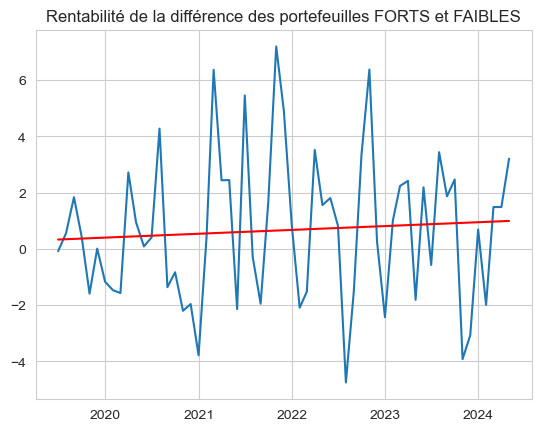

In [91]:
# Dessinons ce rendement moyen sur la période complète pour avoir une idée de la façon dont il bouge

# On va tracer une droite de tendance en + sur le graphique
# préparons les données des abscisses 'x' pour la bonne longueur, celle du dataset
# les données 'x' vont servir au calcul de la droite de régression
x = np.arange(len(famafrench_factor_data))


# Calculer la droite de régression linéaire
# On commence par calculer la pente 'slope' et l'ordonnée à l'origine 'intercept'
slope, intercept = np.polyfit(x, famafrench_factor_data['RMW'], 1) # 1 pour polynome de degré 1 type ax+b
linear_fit = slope * x + intercept

# Tracer les données
plt.plot(famafrench_factor_data['RMW'])
plt.title('Rentabilité de la différence des portefeuilles FORTS et FAIBLES')

# Tracer la droite de régression
plt.plot(famafrench_factor_data['RMW'].index, 
         linear_fit, 
         color='red', 
         label=f'Droite de régression (pente={slope:.4f})')

Le rendement moyen de la différence des portefeuilles est :  0.6644067796610171  %


Text(0, 0.5, 'Effectifs')

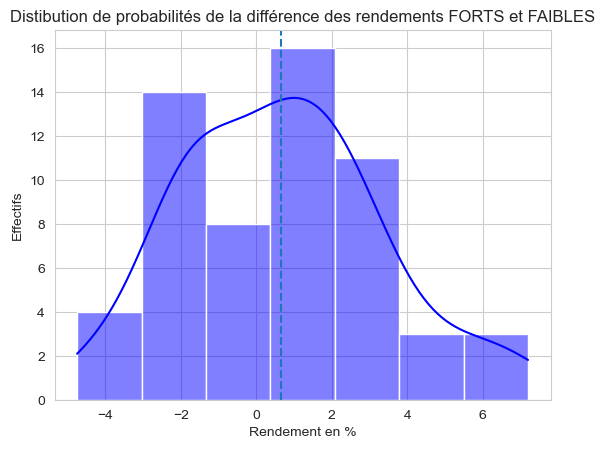

In [86]:
# Dessinons la distribution du rendement de la différence des portefeuilles robuste et faibles sur la 
# période 
# plt.hist(famafrench_factor_data['RMW'], color='blue')

rendement_moyen_diff_portefeuilles = famafrench_factor_data['RMW'].mean()

# avec la méthode de plot suivante et le module seaborn on peut ploter la densité continue en plus
sns.histplot(famafrench_factor_data['RMW'], kde=True, color='blue')

print('Le rendement moyen de la différence des portefeuilles est : ' ,
      rendement_moyen_diff_portefeuilles,
     ' %')

# On trace la moyenne en tant que barre verticale et on donne des caractéristiques pour notre tracé
plt.axvline(rendement_moyen_diff_portefeuilles, 
           linestyle='dashed',
           linewidth=1.5,
           label=f'Moyenne = {rendement_moyen_diff_portefeuilles:.2f}')


plt.title('Distibution de probabilités de la différence des rendements FORTS et FAIBLES')
plt.xlabel('Rendement en %')
plt.ylabel('Effectifs')

# On s'aperçoit que la différence des rendements tourne en moyenne autour de 0 mais 

In [16]:
# start = datetime(2020, 1, 1)
# end = datetime(2023, 1, 1)


# # Récupérer les données du CAC40 depuis Yahoo Finance avec yfinance
# cac40_data = yf.download('^FCHI', start=start, end=end)

# # Afficher les premières lignes des données récupérées
# print(cac40_data.head())

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-01-02  6016.609863  6062.919922  6011.209961  6041.500000  6041.500000   
2020-01-03  6007.959961  6044.160156  5994.589844  6044.160156  6044.160156   
2020-01-06  6001.209961  6017.970215  5955.250000  6013.589844  6013.589844   
2020-01-07  6033.220215  6065.740234  6000.000000  6012.350098  6012.350098   
2020-01-08  5986.810059  6031.000000  5972.770020  6031.000000  6031.000000   

              Volume  
Date                  
2020-01-02  63958300  
2020-01-03  60488000  
2020-01-06  69063700  
2020-01-07  69593800  
2020-01-08  71431600  
